### Final script - comparing risk_score.csv

Columns in dfA but not in dfB: {'area-x', 'revenue-cr', 'are-new', 'revenue-ci-x', 'mean-sexratio', 'area-y', 'district-3-x.1', 'road-count', 'are-new-x', 'revenue-cr-x', 'district-1-x', 'revenue-ci-x.1', 'revenue-cr-y', 'hq', 'are-new-y', 'hq-y', 'revenue-ci-y', 'count-x', 'area', 'hq-x', 'district-3-y.1', 'unnamed:-0-y', 'district-1', 'district-3-x', 'unnamed:-0-x', 'revenue-ci-y.1', 'district-1-y', 'count-y', 'district-3-y'}
Columns in dfB but not in dfA: {'female-camp', 'sdrf-sanctions-awarded-value', 'efficiency', 'dtname', 'human-live-lost-male', 'human-live-lost-children', 'male-camp', 'children-camp', 'human-live-lost-female', 'object_id_new', 'dtcode11', 'revenue-ci', 'mean-sex-ratio'}
Column Data Type Comparison: {'road-length': (dtype('float64'), dtype('float64')), 'rc-area': (dtype('int64'), dtype('int64')), 'drainage-density': (dtype('float64'), dtype('float64')), 'sdrf-tenders-awarded-value': (dtype('float64'), dtype('float64')), 'built-area': (dtype('float64'), dtype('fl

c:\Users\saura\anaconda3\envs\cdl-env\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


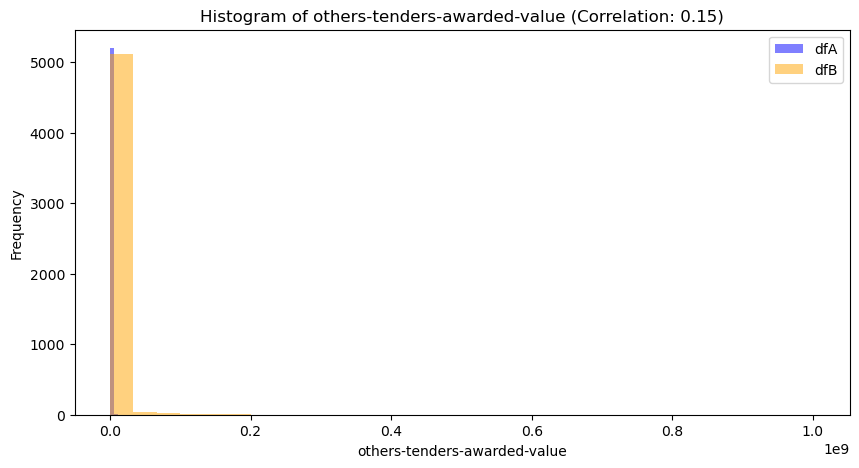

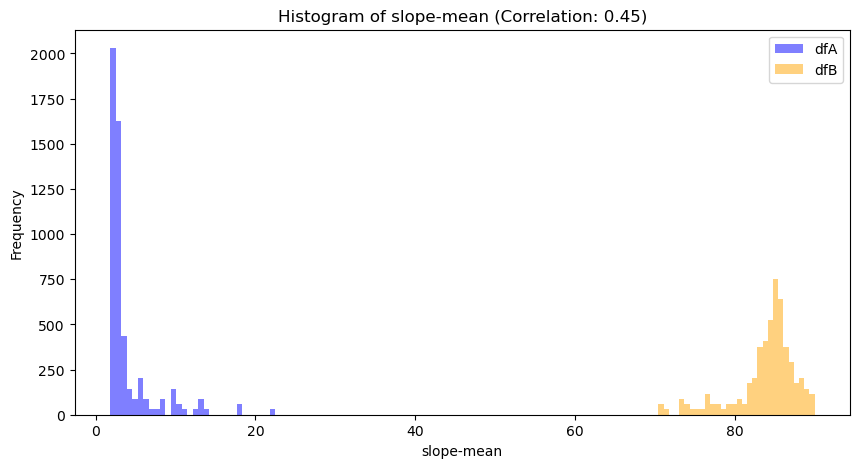

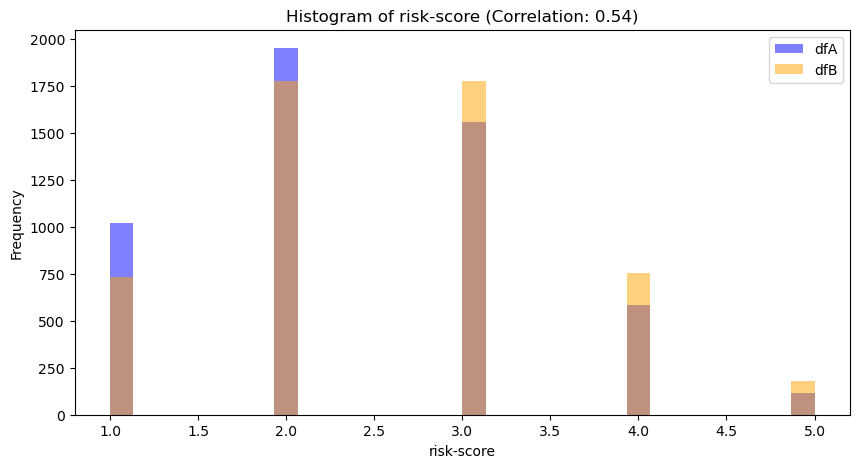

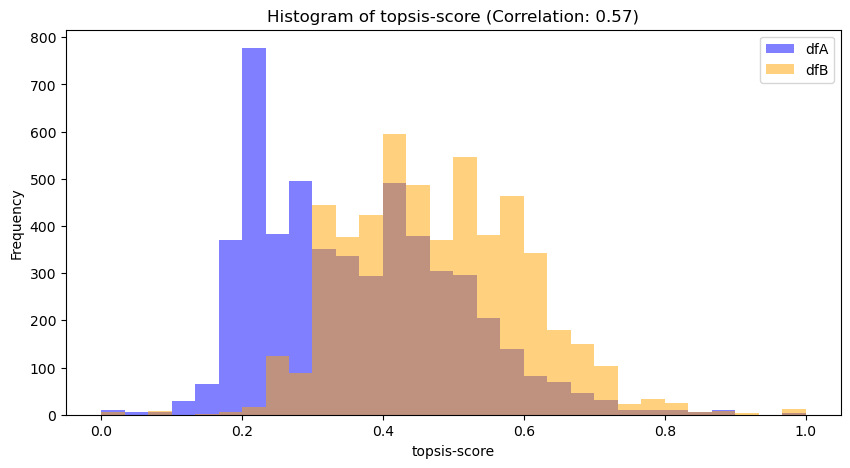

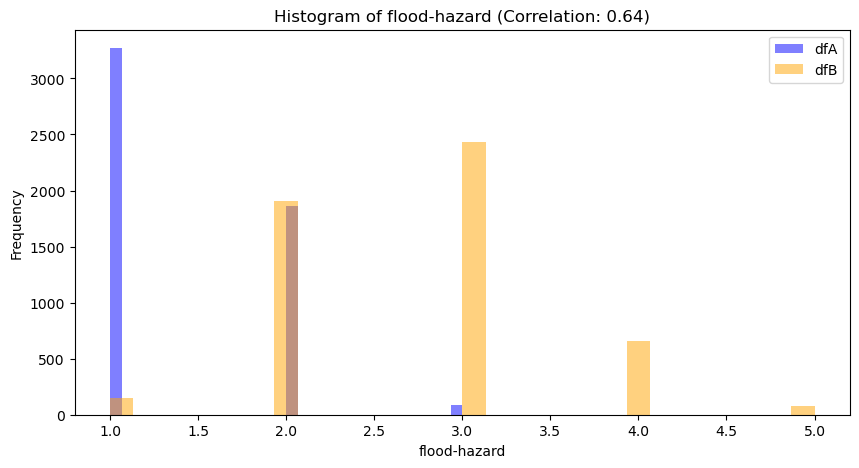

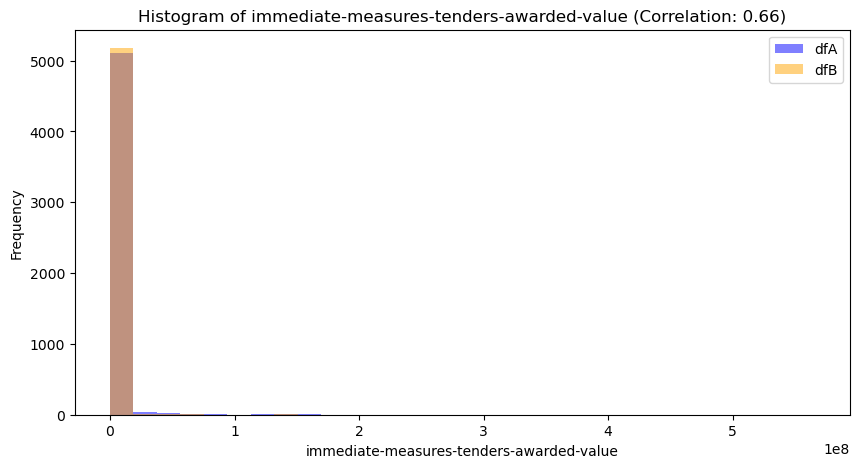

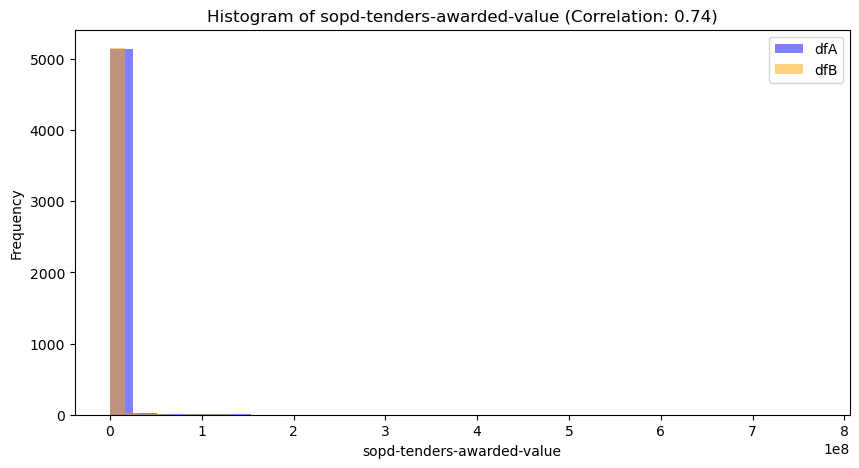

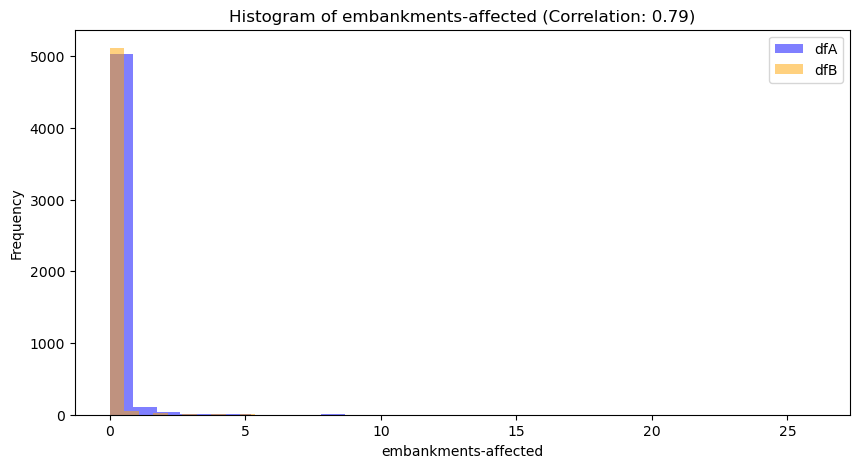

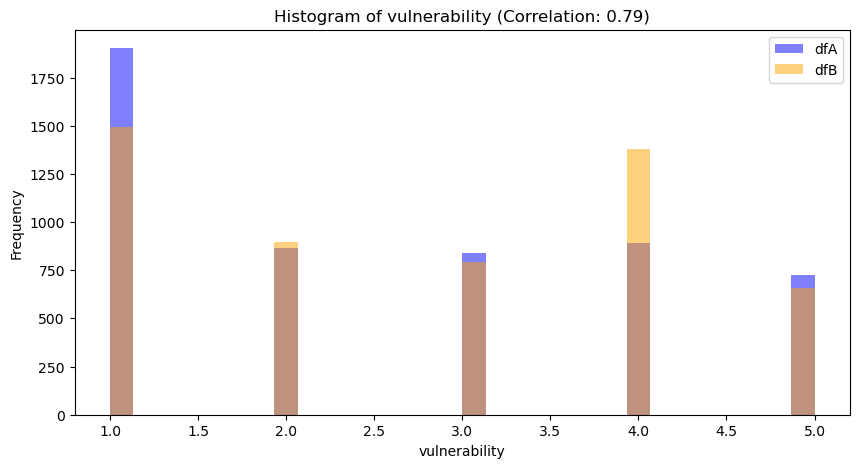

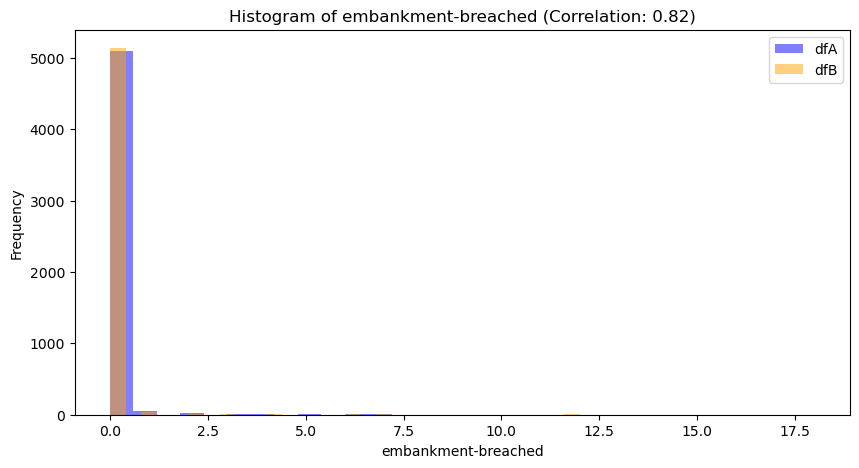

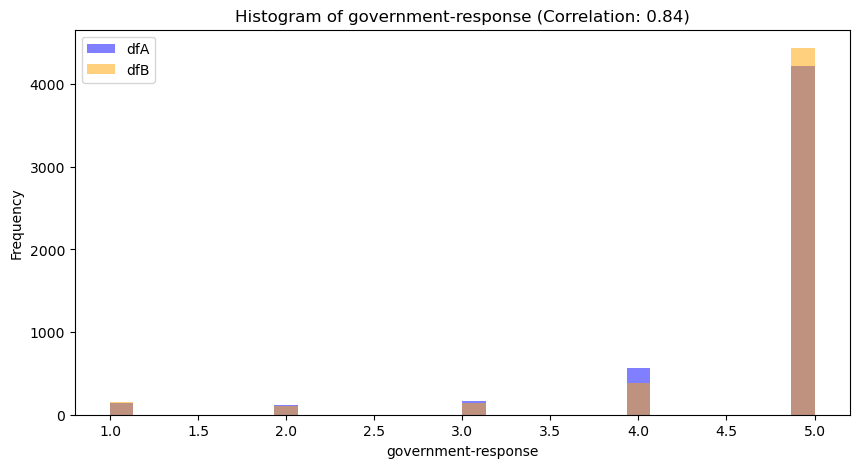

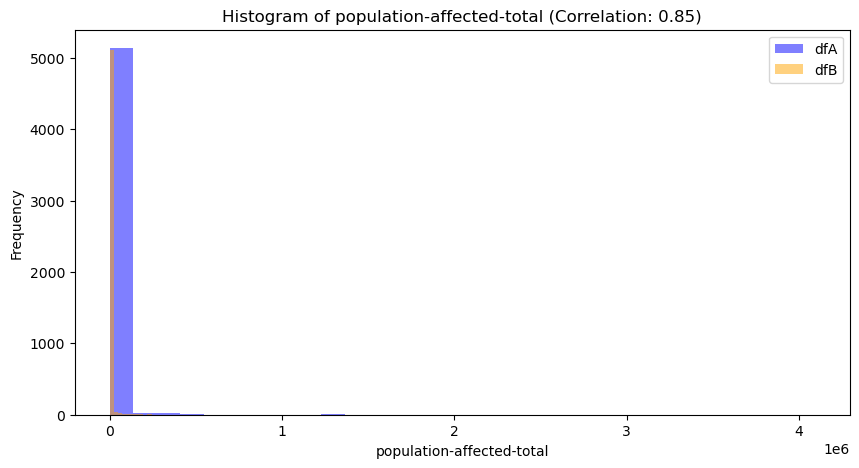

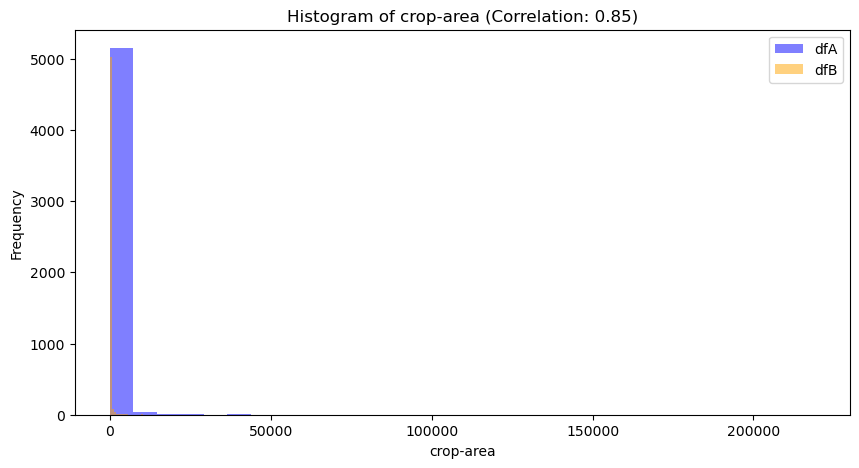

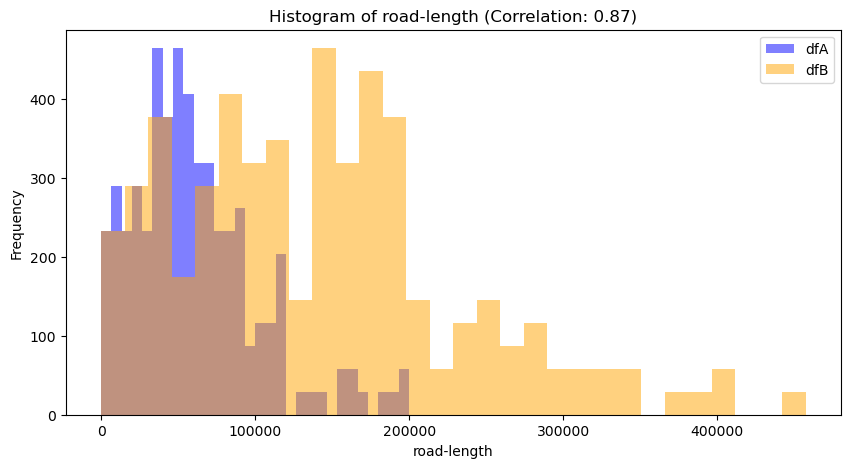

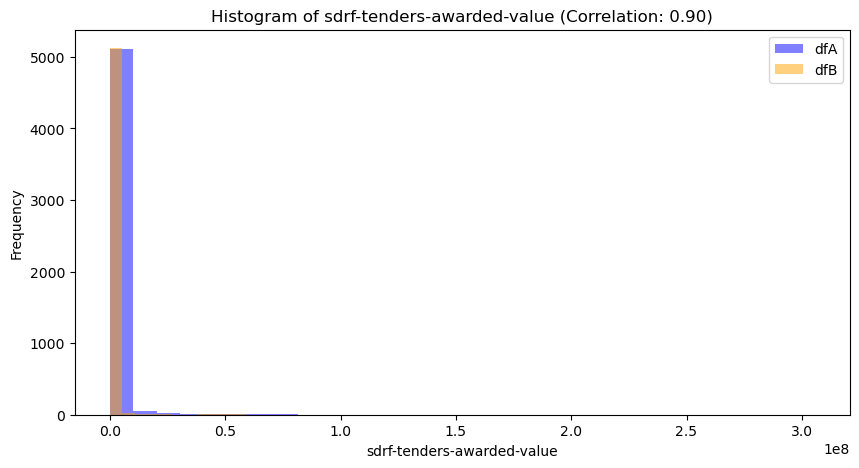

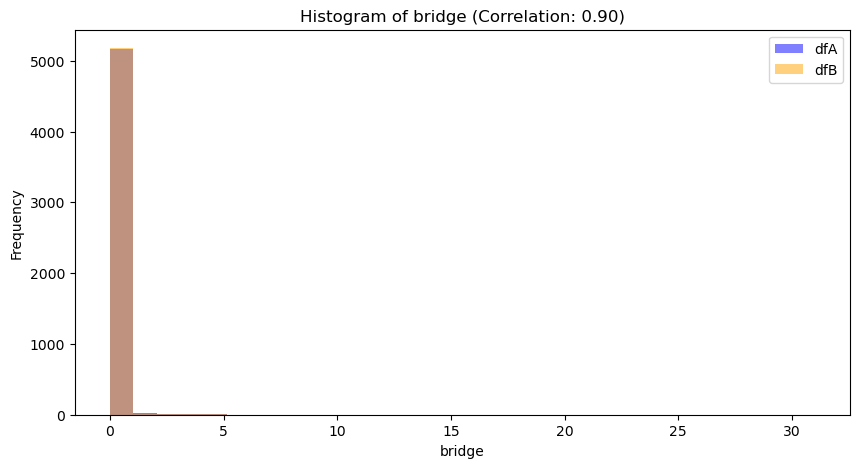

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency
import numpy as np

# Load Data

dfA = pd.read_csv(r"C:\Users\saura\Downloads\risk_score.csv")
dfB = pd.read_csv(r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\IDS-DRR-Assam-Risk-Model\RiskScoreModel\data\risk_score.csv")

# Preprocessing
dfB['object_id_old'] = dfB['object-id'].str[9:13]
dfB = dfB.rename(columns={'object-id': 'object_id_new', 'object_id_old': 'object-id'})
dates = ['2023_09', '2023_10',
         '2023_11',
         '2023_12',
         '2024_01',
         '2024_02',
         '2024_03',
         '2024_04',
         '2024_05',
         '2024_06',
         '2024_07',
         '2024_08',
         '2024_09',
         '2024_10',
         '2024_11',
         '2024_12']
dfB = dfB[~dfB['timeperiod'].isin(dates)]
dfB['object-id'] = dfB['object-id'].astype(int)

# Compare Column Names
missing_in_dfB = set(dfA.columns) - set(dfB.columns)
missing_in_dfA = set(dfB.columns) - set(dfA.columns)

print("Columns in dfA but not in dfB:", missing_in_dfB)
print("Columns in dfB but not in dfA:", missing_in_dfA)

shared_columns = set(dfA.columns) & set(dfB.columns)
dtype_comparison = {col: (dfA[col].dtype, dfB[col].dtype) for col in shared_columns}
print("Column Data Type Comparison:", dtype_comparison)

# Filter shared columns with matching data types
shared_columns = {col for col in shared_columns if dtype_comparison[col][0] == dtype_comparison[col][1]}
dfB = dfB.sort_values(by=['object-id', 'timeperiod']).reset_index(drop=True)
dfA = dfA.sort_values(by=['object-id', 'timeperiod']).reset_index(drop=True)

# Correlation and Overlap Calculations
column_comparison = {}

for col in shared_columns:
    if np.issubdtype(dfA[col].dtype, np.number):  # Numeric columns
        correlation = dfA[col].corr(dfB[col])
        column_comparison[col] = {
            'type': 'numeric',
            'correlation': correlation
        }
        print(f"Correlation for {col}: {correlation}")
    else:  # Categorical or non-numeric columns
        overlap = len(set(dfA[col]) & set(dfB[col])) / len(set(dfA[col]) | set(dfB[col]))
        column_comparison[col] = {
            'type': 'categorical',
            'overlap': overlap
        }
        print(f"Overlap for {col}: {overlap}")

# Plot histograms for low correlation columns
low_correlation_columns = [col for col, stats in column_comparison.items() if stats['type'] == 'numeric' and abs(stats['correlation']) < 0.9]
low_correlation_columns = sorted(low_correlation_columns, key=lambda col: abs(column_comparison[col]['correlation']))
for col in low_correlation_columns:
    plt.figure(figsize=(10, 5))
    plt.hist(dfA[col].dropna(), bins=30, alpha=0.5, label='dfA', color='blue')
    plt.hist(dfB[col].dropna(), bins=30, alpha=0.5, label='dfB', color='orange')
    plt.title(f'Histogram of {col} (Correlation: {column_comparison[col]["correlation"]:.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


### Advanced tests

In [9]:
for col in shared_columns:
    if np.issubdtype(dfA[col].dtype, np.number):
        dfA[f'{col}_abs_diff'] = abs(dfA[col] - dfB[col])
        dfA[f'{col}_percent_change'] = abs((dfA[col] - dfB[col]) / dfA[col]) * 100

# Identify top impacted revenue circles and time periods
numeric_diff_columns = [f'{col}_abs_diff' for col in shared_columns if np.issubdtype(dfA[col].dtype, np.number)]
impact_summary = dfA.groupby(['object-id', 'timeperiod'])[numeric_diff_columns].mean().sort_values(by=numeric_diff_columns[0], ascending=False)
print(impact_summary.head(10))


                      road-length_abs_diff  rc-area_abs_diff  \
object-id timeperiod                                           
255       2021_04            368148.057367               0.0   
          2021_06            368148.057367               0.0   
          2023_08            368148.057367               0.0   
          2023_07            368148.057367               0.0   
          2023_06            368148.057367               0.0   
          2023_05            368148.057367               0.0   
          2023_04            368148.057367               0.0   
          2023_03            368148.057367               0.0   
          2023_02            368148.057367               0.0   
          2023_01            368148.057367               0.0   

                      drainage-density_abs_diff  \
object-id timeperiod                              
255       2021_04                           0.0   
          2021_06                           0.0   
          2023_08          

In [16]:
for col in shared_columns:
    if np.issubdtype(dfA[col].dtype, np.number):
        dfA[f'{col}_rank'] = dfA[col].rank()
        dfB[f'{col}_rank'] = dfB[col].rank()
        dfA[f'{col}_rank_diff'] = abs(dfA[f'{col}_rank'] - dfB[f'{col}_rank'])

# Filter only numeric rank_diff columns
numeric_rank_diff_columns = [f'{col}_rank_diff' for col in shared_columns if f'{col}_rank_diff' in dfA.columns and np.issubdtype(dfA[f'{col}_rank_diff'].dtype, np.number)]

# Highlight revenue circles with the largest rank changes
rank_changes = dfA.groupby('object-id')[numeric_rank_diff_columns].mean().sort_values(by=numeric_rank_diff_columns[0], ascending=False)
rank_changes

           road-length_rank_diff  rc-area_rank_diff  \
object-id                                             
252                       2233.0                0.0   
137                       1769.0                0.0   
210                       1769.0                0.0   
146                       1740.0                0.0   
179                       1711.0                0.0   
159                       1711.0                0.0   
158                       1682.0                0.0   
120                       1595.0                0.0   
261                       1566.0                0.0   
196                       1508.0                0.0   

           drainage-density_rank_diff  sdrf-tenders-awarded-value_rank_diff  \
object-id                                                                     
252                               0.0                             33.500000   
137                               0.0                             33.500000   
210                    

In [17]:
for col in shared_columns:
    if np.issubdtype(dfA[col].dtype, np.number):
        t_stat, p_value = ttest_ind(dfA[col].dropna(), dfB[col].dropna(), equal_var=False)
        print(f"T-Test for {col}: t-stat={t_stat}, p-value={p_value}")


T-Test for road-length: t-stat=-57.39613968485896, p-value=0.0
T-Test for rc-area: t-stat=0.0, p-value=1.0
T-Test for drainage-density: t-stat=0.0, p-value=1.0
T-Test for sdrf-tenders-awarded-value: t-stat=1.91509690900966, p-value=0.05550876178000669
T-Test for built-area: t-stat=0.0, p-value=1.0
T-Test for bare-ground: t-stat=0.0, p-value=1.0
T-Test for avg-tele: t-stat=0.0, p-value=1.0
T-Test for mean-rain: t-stat=0.0, p-value=1.0
T-Test for riverlevel-min: t-stat=0.0, p-value=1.0
T-Test for distance-from-river: t-stat=0.0, p-value=1.0
T-Test for sum-rain: t-stat=0.0, p-value=1.0
T-Test for others-tenders-awarded-value: t-stat=-6.9846693799122646, p-value=3.193281265122294e-12
T-Test for rc-nosanitation-hhds-pct: t-stat=0.05411297387177934, p-value=0.9568461913406583
T-Test for population-affected-total: t-stat=5.546971053393112, p-value=3.0428426079938684e-08
T-Test for riverlevel-mean: t-stat=0.0, p-value=1.0
T-Test for water: t-stat=0.0, p-value=1.0
T-Test for riverlevel-max: t-s

In [18]:
for col in shared_columns:
    if np.issubdtype(dfA[col].dtype, np.number):
        ks_stat, ks_p_value = ks_2samp(dfA[col].dropna(), dfB[col].dropna())
        print(f"KS Test for {col}: ks-stat={ks_stat}, p-value={ks_p_value}")


KS Test for road-length: ks-stat=0.5, p-value=0.0
KS Test for rc-area: ks-stat=0.0, p-value=1.0
KS Test for drainage-density: ks-stat=0.0, p-value=1.0
KS Test for sdrf-tenders-awarded-value: ks-stat=0.012835249042145594, p-value=0.7831375431914603
KS Test for built-area: ks-stat=0.0, p-value=1.0
KS Test for bare-ground: ks-stat=0.0, p-value=1.0
KS Test for avg-tele: ks-stat=0.0, p-value=1.0
KS Test for mean-rain: ks-stat=0.0005747126436781609, p-value=0.9999999999999994
KS Test for riverlevel-min: ks-stat=0.0, p-value=1.0
KS Test for distance-from-river: ks-stat=0.0, p-value=1.0
KS Test for sum-rain: ks-stat=0.00019157088122605365, p-value=0.9999999999999998
KS Test for others-tenders-awarded-value: ks-stat=0.034482758620689655, p-value=0.004028403314884381
KS Test for rc-nosanitation-hhds-pct: ks-stat=0.016666666666666666, p-value=0.4631265566155762
KS Test for population-affected-total: ks-stat=0.03007662835249042, p-value=0.017789553494459757
KS Test for riverlevel-mean: ks-stat=0.0

In [19]:
for col in shared_columns:
    if not np.issubdtype(dfA[col].dtype, np.number):
        contingency_table = pd.crosstab(dfA[col], dfB[col])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"Chi-Square Test for {col}: chi2={chi2}, p-value={p}")


Chi-Square Test for district: chi2=177480.0, p-value=0.0
Chi-Square Test for timeperiod: chi2=146159.99999999994, p-value=0.0


In [21]:
for col in shared_columns:
    if np.issubdtype(dfA[col].dtype, np.number):
        dfA[f'{col}_zscore'] = (dfA[col] - dfA[col].mean()) / dfA[col].std()
        dfB[f'{col}_zscore'] = (dfB[col] - dfB[col].mean()) / dfB[col].std()
        dfA[f'{col}_zscore_diff'] = abs(dfA[f'{col}_zscore'] - dfB[f'{col}_zscore'])

# Identify areas with extreme z-score differences
numeric_zscore_diff_columns = [f'{col}_zscore_diff' for col in shared_columns if f'{col}_zscore_diff' in dfA.columns and np.issubdtype(dfA[f'{col}_zscore_diff'].dtype, np.number)]
outliers = dfA.groupby('object-id')[numeric_zscore_diff_columns].mean().sort_values(by=numeric_zscore_diff_columns[0], ascending=False)
print(outliers.head(10))


           road-length_zscore_diff  rc-area_zscore_diff  \
object-id                                                 
255                       2.755570                  0.0   
264                       1.579461                  0.0   
180                       1.455314                  0.0   
254                       1.334311                  0.0   
270                       1.222929                  0.0   
137                       1.199802                  0.0   
187                       1.130962                  0.0   
252                       1.031316                  0.0   
192                       0.968483                  0.0   
170                       0.928713                  0.0   

           drainage-density_zscore_diff  \
object-id                                 
255                                 0.0   
264                                 0.0   
180                                 0.0   
254                                 0.0   
270                              

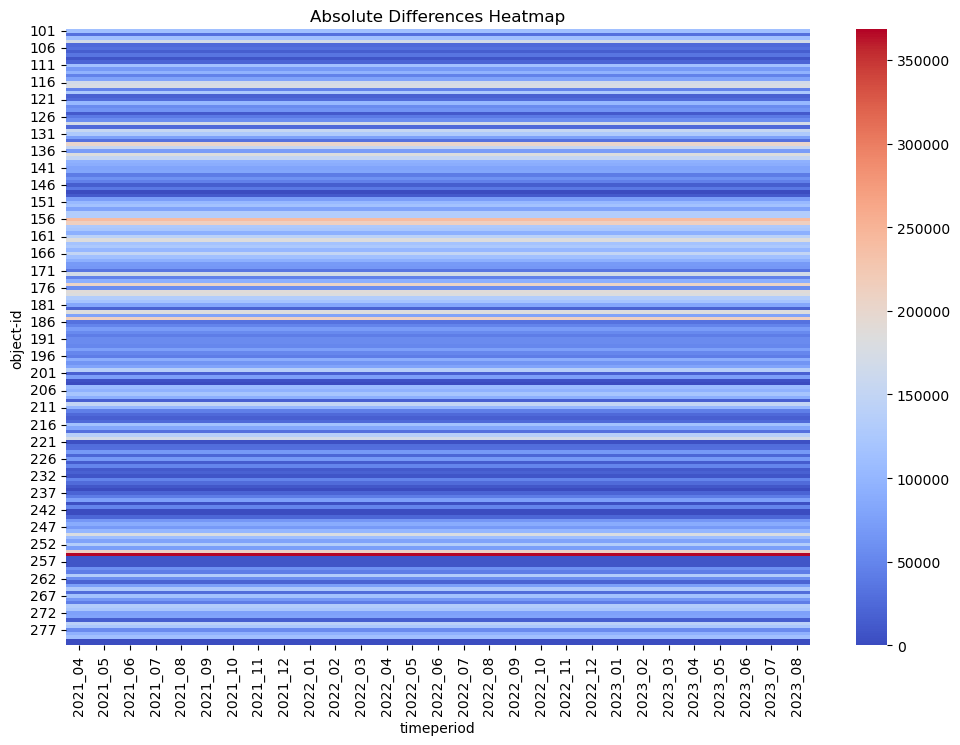

In [24]:
import seaborn as sns

# Filter only numeric columns for aggregation
numeric_diff_columns = [f'{col}_abs_diff' for col in shared_columns if f'{col}_abs_diff' in dfA.columns and np.issubdtype(dfA[f'{col}_abs_diff'].dtype, np.number)]

# Aggregate absolute differences
heatmap_data = dfA.groupby(['object-id', 'timeperiod'])[numeric_diff_columns].mean().reset_index()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.pivot(index='object-id', columns='timeperiod', values=numeric_diff_columns[0]), cmap='coolwarm', annot=False)
plt.title('Absolute Differences Heatmap')
plt.show()


In [26]:
# Ensure only numeric columns are included in the aggregation
numeric_columns = [f'{col}_abs_diff' for col in shared_columns if f'{col}_abs_diff' in dfA.columns and np.issubdtype(dfA[f'{col}_abs_diff'].dtype, np.number)] + \
				  [f'{col}_rank_diff' for col in shared_columns if f'{col}_rank_diff' in dfA.columns and np.issubdtype(dfA[f'{col}_rank_diff'].dtype, np.number)]

summary = dfA.groupby(['object-id', 'timeperiod'])[numeric_columns].mean()
summary['total_impact'] = summary.sum(axis=1)
summary = summary.sort_values(by='total_impact', ascending=False)
print(summary.head(10))


                      road-length_abs_diff  rc-area_abs_diff  \
object-id timeperiod                                           
124       2022_06             63332.567160               0.0   
219       2022_03            137998.463838               0.0   
271       2022_06            121687.364644               0.0   
152       2022_07            115283.397534               0.0   
269       2023_05             42097.205798               0.0   
128       2021_12            171040.962495               0.0   
185       2023_05            212386.713184               0.0   
159       2023_05            121889.914830               0.0   
          2023_06            121889.914830               0.0   
150       2022_02             72194.940893               0.0   

                      drainage-density_abs_diff  \
object-id timeperiod                              
124       2022_06                           0.0   
219       2022_03                           0.0   
271       2022_06          

C:\Users\saura\AppData\Local\Temp\ipykernel_11496\986634549.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  summary['total_impact'] = summary.sum(axis=1)


### Analysis of MASTER_VARIABLES.csv

Columns in dfA but not in dfB: {'mean_sexratio', 'road_count', 'ndbi_mean'}
Columns in dfB but not in dfA: {'dtcode11', 'dtname', 'Children_Camp', 'Male_Camp', 'SDRF_sanctions_awarded_value', 'Human_Live_Lost_Male', 'Female_Camp', 'object_id_new', 'count', 'mean_sex_ratio', 'mean_ndbi', 'Human_Live_Lost_Female', 'Human_Live_Lost_Children', 'revenue_ci'}
Column Data Type Comparison: {'bare_ground': (dtype('float64'), dtype('float64')), 'crops': (dtype('float64'), dtype('float64')), 'Roads': (dtype('float64'), dtype('float64')), 'Total_House_Fully_Damaged': (dtype('float64'), dtype('float64')), 'sum_rain': (dtype('float64'), dtype('float64')), 'rc_piped_hhds_pct': (dtype('float64'), dtype('float64')), 'SOPD_tenders_awarded_value': (dtype('float64'), dtype('float64')), 'riverlevel_max': (dtype('float64'), dtype('float64')), 'health_centres_count': (dtype('int64'), dtype('int64')), 'riverlevel_mean': (dtype('float64'), dtype('float64')), 'Bridge': (dtype('float64'), dtype('float64')), 'RID

c:\Users\saura\anaconda3\envs\cdl-env\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


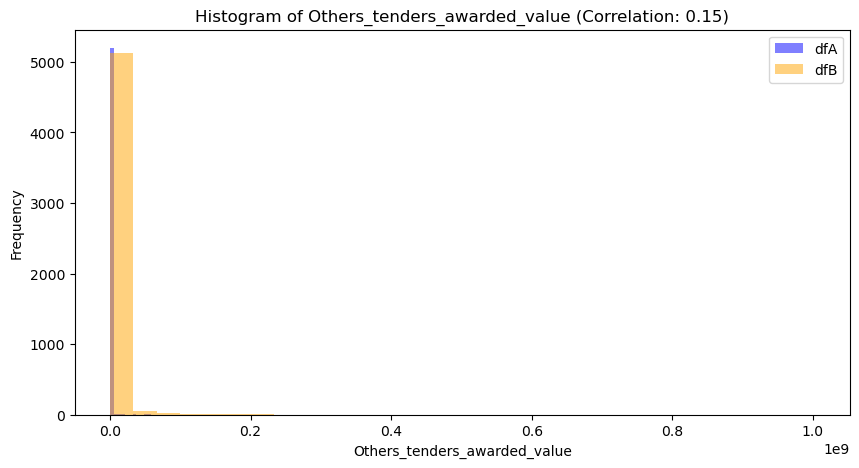

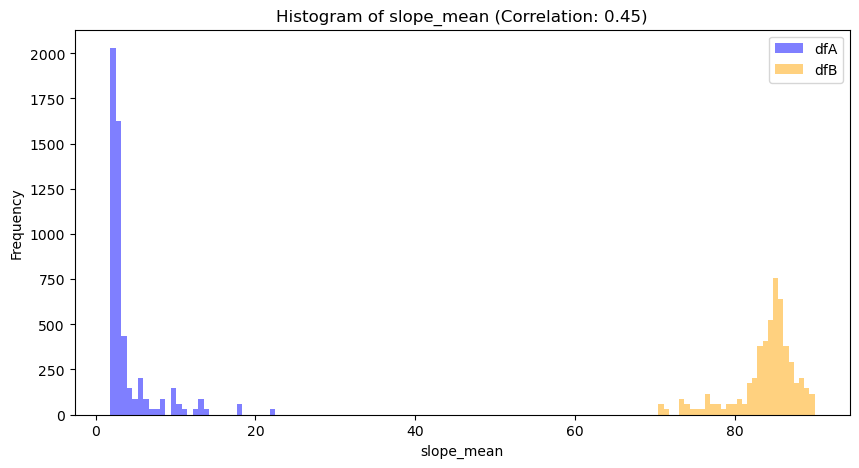

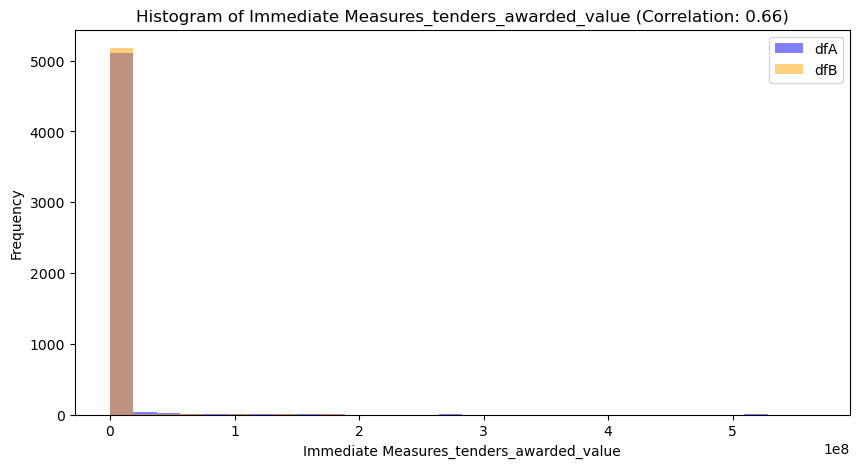

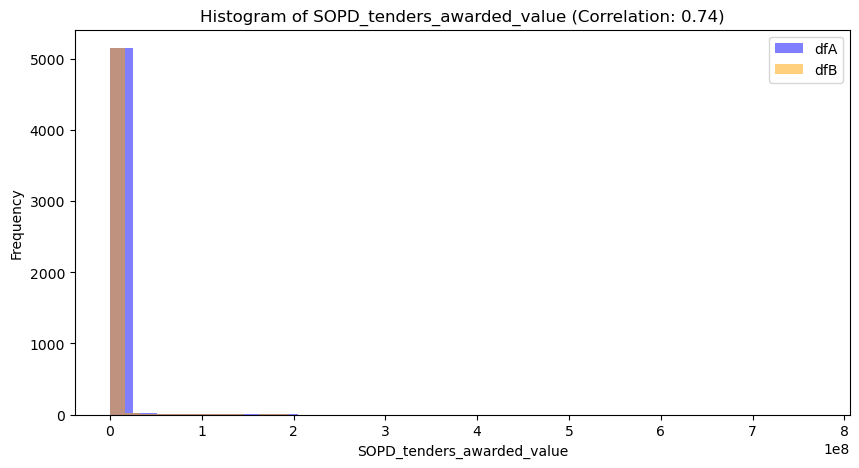

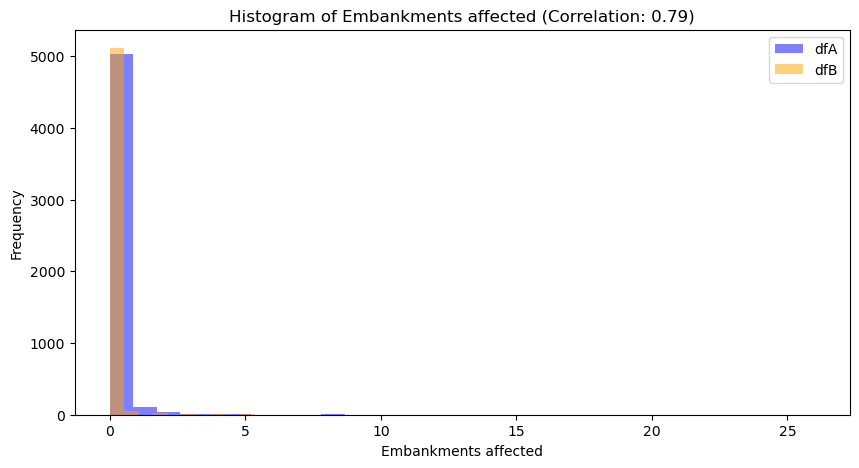

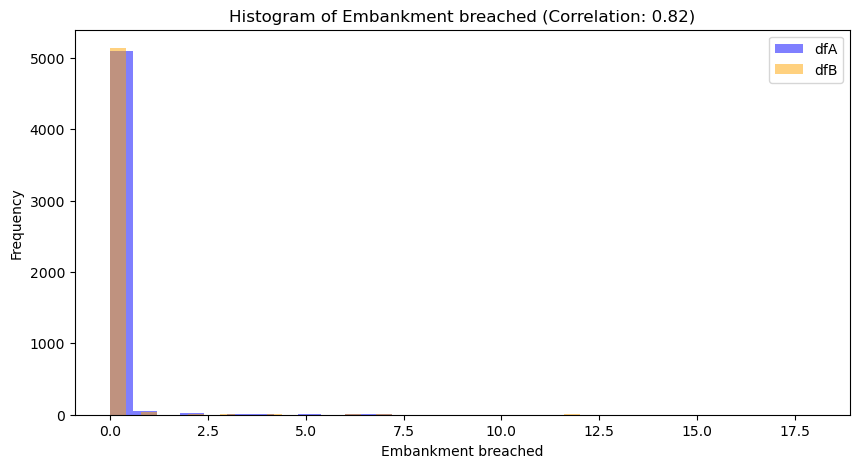

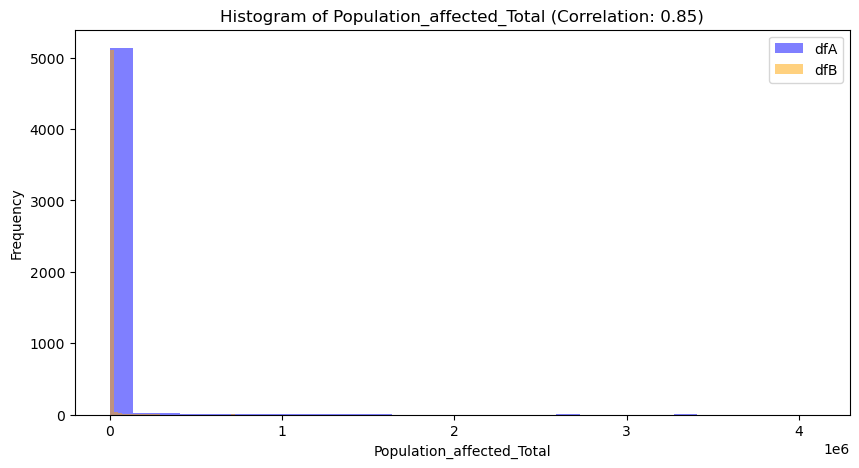

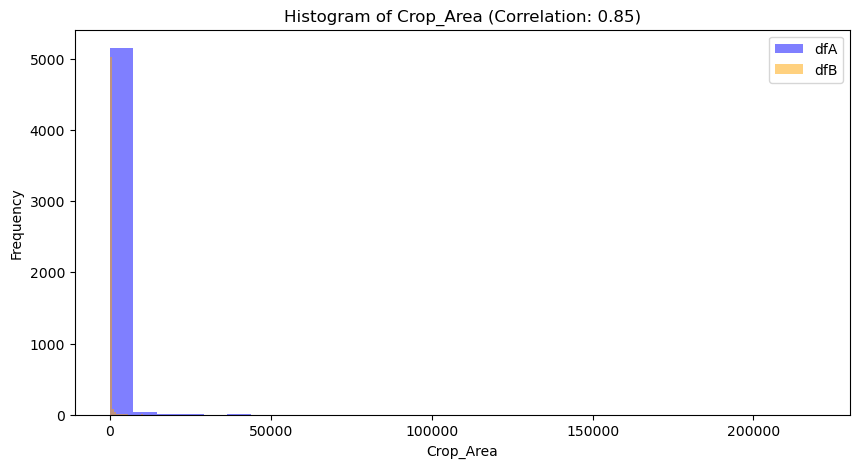

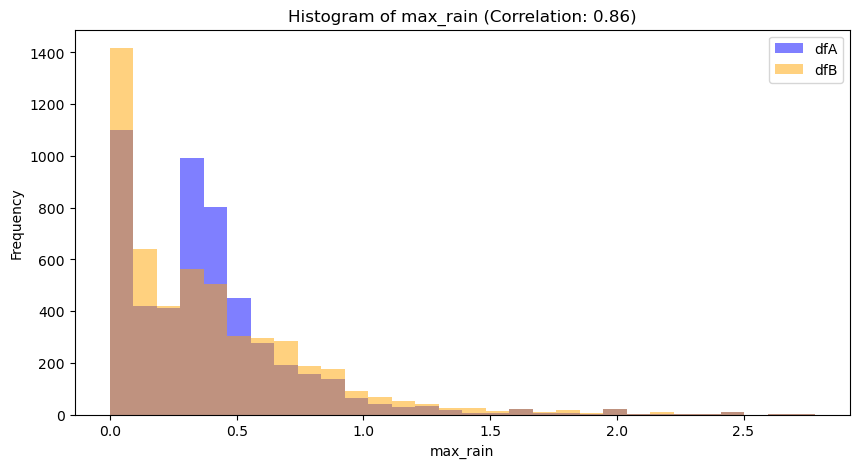

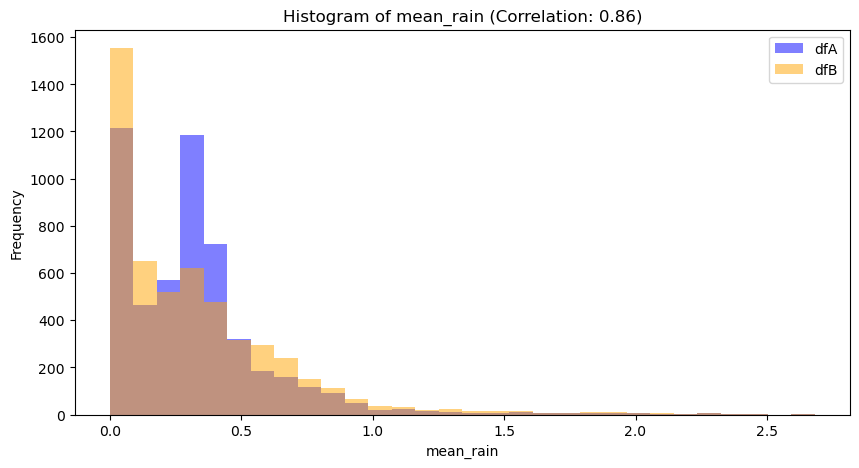

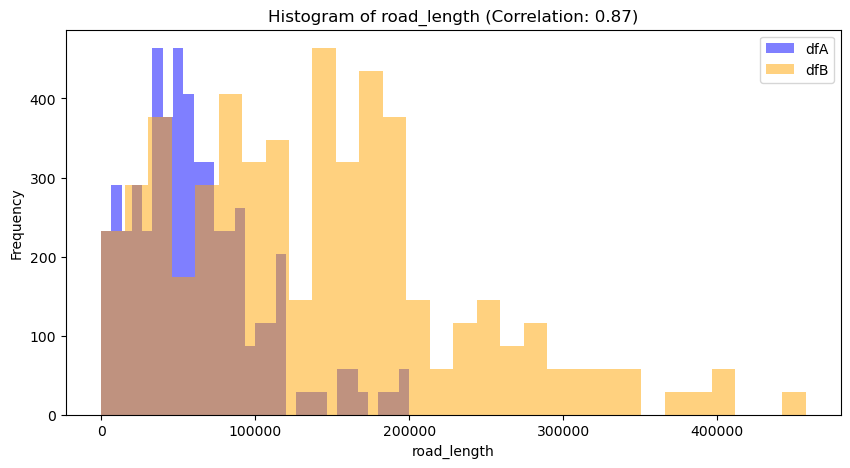

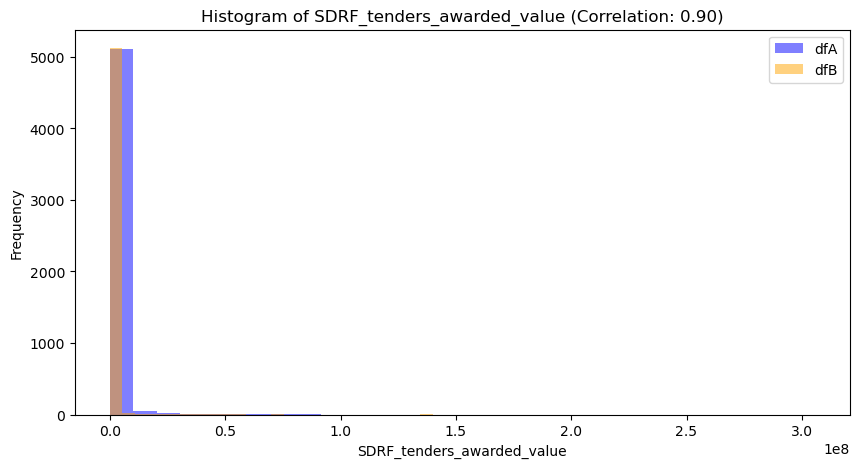

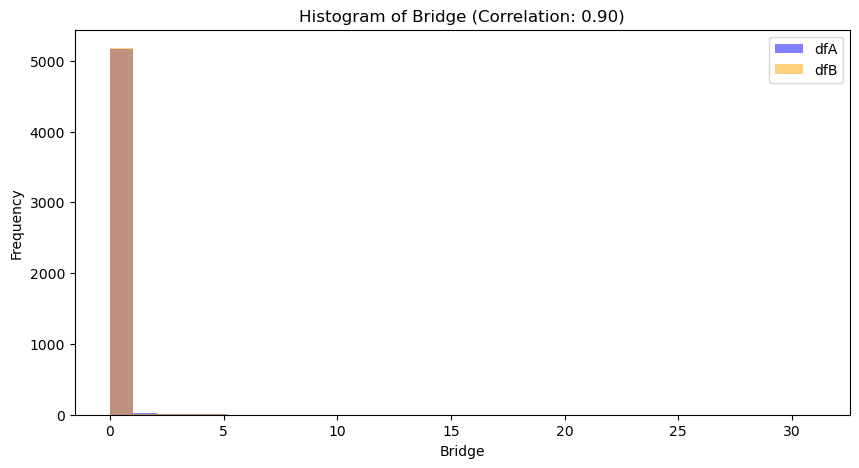

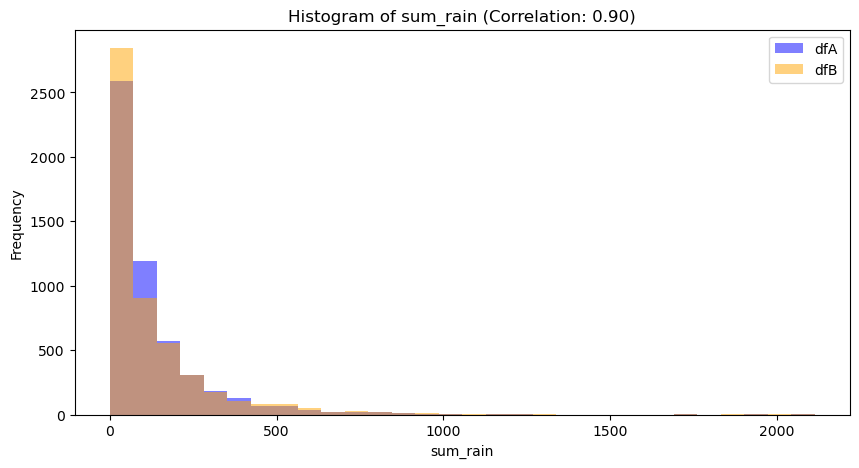

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency
import numpy as np

# Load Data

dfA = pd.read_csv(r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\IDS-DRR-Assam-Risk-Model\RiskScoreModel\data\MASTER_VARIABLES_archive.csv")
dfB = pd.read_csv(r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\IDS-DRR-Assam-Risk-Model\RiskScoreModel\data\MASTER_VARIABLES.csv")

# Preprocessing
dfB['object_id_old'] = dfB['object_id'].str[9:13]
dfB = dfB.rename(columns={'object_id': 'object_id_new', 'object_id_old': 'object_id'})
dates = ['2023_09', '2023_10',
         '2023_11',
         '2023_12',
         '2024_01',
         '2024_02',
         '2024_03',
         '2024_04',
         '2024_05',
         '2024_06',
         '2024_07',
         '2024_08',
         '2024_09',
         '2024_10',
         '2024_11',
         '2024_12']
dfB = dfB[~dfB['timeperiod'].isin(dates)]
dfB['object_id'] = dfB['object_id'].astype(int)

# Compare Column Names
missing_in_dfB = set(dfA.columns) - set(dfB.columns)
missing_in_dfA = set(dfB.columns) - set(dfA.columns)

print("Columns in dfA but not in dfB:", missing_in_dfB)
print("Columns in dfB but not in dfA:", missing_in_dfA)

shared_columns = set(dfA.columns) & set(dfB.columns)
dtype_comparison = {col: (dfA[col].dtype, dfB[col].dtype) for col in shared_columns}
print("Column Data Type Comparison:", dtype_comparison)

# Filter shared columns with matching data types
shared_columns = {col for col in shared_columns if dtype_comparison[col][0] == dtype_comparison[col][1]}
dfB = dfB.sort_values(by=['object_id', 'timeperiod']).reset_index(drop=True)
dfA = dfA.sort_values(by=['object_id', 'timeperiod']).reset_index(drop=True)

# Correlation and Overlap Calculations
column_comparison = {}

for col in shared_columns:
    if np.issubdtype(dfA[col].dtype, np.number):  # Numeric columns
        correlation = dfA[col].corr(dfB[col])
        column_comparison[col] = {
            'type': 'numeric',
            'correlation': correlation
        }
        print(f"Correlation for {col}: {correlation}")
    else:  # Categorical or non-numeric columns
        overlap = len(set(dfA[col]) & set(dfB[col])) / len(set(dfA[col]) | set(dfB[col]))
        column_comparison[col] = {
            'type': 'categorical',
            'overlap': overlap
        }
        print(f"Overlap for {col}: {overlap}")

# Plot histograms for low correlation columns
low_correlation_columns = [col for col, stats in column_comparison.items() if stats['type'] == 'numeric' and abs(stats['correlation']) < 0.9]
low_correlation_columns = sorted(low_correlation_columns, key=lambda col: abs(column_comparison[col]['correlation']))
for col in low_correlation_columns:
    plt.figure(figsize=(10, 5))
    plt.hist(dfA[col].dropna(), bins=30, alpha=0.5, label='dfA', color='blue')
    plt.hist(dfB[col].dropna(), bins=30, alpha=0.5, label='dfB', color='orange')
    plt.title(f'Histogram of {col} (Correlation: {column_comparison[col]["correlation"]:.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


### Steps

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency1
import numpy as np

ImportError: cannot import name 'chi2_contingency1' from 'scipy.stats' (c:\Users\saura\anaconda3\envs\cdl-env\Lib\site-packages\scipy\stats\__init__.py)

In [121]:
dfA = pd.read_csv(r"C:\Users\saura\Downloads\factor_scores_l1_vulnerability.csv")
dfB = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\IDS-DRR-Assam-Risk-Model\RiskScoreModel\data\factor_scores_l1_vulnerability.csv')


In [ ]:
dfB['object_id_old'] = dfB['object_id'].str[9:13]
dfB = dfB.rename(columns={'object_id':'object_id_new','object_id_old':'object_id'})
dates = ['2023_09','2023_10',
 '2023_11',
 '2023_12',
 '2024_01',
 '2024_02',
 '2024_03',
 '2024_04',
 '2024_05',
 '2024_06',
 '2024_07',
 '2024_08',
 '2024_09',
 '2024_10',
 '2024_11',
 '2024_12']
dfB = dfB[~dfB['timeperiod'].isin(dates)]
dfB['object_id'] = dfB['object_id'].astype(int)

In [123]:
# Comparing columns and structure
missing_in_dfB = set(dfA.columns) - set(dfB.columns)
missing_in_dfA = set(dfB.columns) - set(dfA.columns)

print("Columns in dfA but not in dfB:", missing_in_dfB)
print("Columns in dfB but not in dfA:", missing_in_dfA)


Columns in dfA but not in dfB: {'revenue_ci_x', 'area_y', 'road_count', 'Unnamed: 0_x', 'area', 'revenue_ci_y.1', 'district_1', 'HQ', 'are_new_x', 'Unnamed: 0_y', 'district_1_y', 'district_3_x', 'area_x', 'are_new_y', 'count_x', 'are_new', 'mean_sexratio', 'district_3_y.1', 'revenue_cr', 'revenue_cr_y', 'revenue_cr_x', 'district_1_x', 'HQ_x', 'district_3_y', 'revenue_ci_y', 'HQ_y', 'district_3_x.1', 'revenue_ci_x.1', 'count_y'}
Columns in dfB but not in dfA: {'mean_sex_ratio', 'Female_Camp', 'object_id_new', 'Male_Camp', 'SDRF_sanctions_awarded_value', 'revenue_ci', 'Human_Live_Lost_Male', 'dtcode11', 'Human_Live_Lost_Female', 'Children_Camp', 'landd_score', 'dtname', 'Human_Live_Lost_Children'}


In [124]:
shared_columns = set(dfA.columns) & set(dfB.columns)
dtype_comparison = {col: (dfA[col].dtype, dfB[col].dtype) for col in shared_columns}
print("Column Data Type Comparison:", dtype_comparison)

Column Data Type Comparison: {'slope_mean': (dtype('float64'), dtype('float64')), 'elevation_mean': (dtype('float64'), dtype('float64')), 'distance_from_river': (dtype('float64'), dtype('float64')), 'Human_Live_Lost': (dtype('int64'), dtype('int64')), 'Total_House_Fully_Damaged': (dtype('float64'), dtype('float64')), 'count': (dtype('float64'), dtype('float64')), 'CIDF_tenders_awarded_value': (dtype('float64'), dtype('float64')), 'inundation_intensity_sum': (dtype('float64'), dtype('float64')), 'LTIF_tenders_awarded_value': (dtype('float64'), dtype('float64')), 'max_rain': (dtype('float64'), dtype('float64')), 'built_area': (dtype('float64'), dtype('float64')), 'avg_tele': (dtype('float64'), dtype('float64')), 'RIDF_tenders_awarded_value': (dtype('float64'), dtype('float64')), 'inundation_intensity_mean': (dtype('float64'), dtype('float64')), 'Population_affected_Total': (dtype('float64'), dtype('float64')), 'crops': (dtype('float64'), dtype('float64')), 'Others_tenders_awarded_value':

In [131]:
shared_columns = {col for col in shared_columns if dtype_comparison[col][0] == dtype_comparison[col][1]}
dfB = dfB.sort_values(by=['object_id', 'timeperiod']).reset_index(drop=True)
dfA = dfA.sort_values(by=[ 'object_id','timeperiod']).reset_index(drop=True)

for col in shared_columns:    

    if np.issubdtype(dfA[col].dtype, np.number):  # Numeric columns
        correlation = dfA[col].corr(dfB[col])
        print(f"Correlation for {col}: {correlation}")
    else:  # Categorical or non-numeric columns
        overlap = len(set(dfA[col]) & set(dfB[col])) / len(set(dfA[col]) | set(dfB[col]))
        print(f"Overlap for {col}: {overlap}")


Correlation for slope_mean: 0.45050550072213286
Correlation for distance_from_river: 0.9999999999999999
Correlation for elevation_mean: 1.0
Correlation for Human_Live_Lost: 0.9683933598401319
Correlation for Total_House_Fully_Damaged: 1.0
Correlation for count: 0.9999999999999999
Correlation for CIDF_tenders_awarded_value: 1.0
Correlation for inundation_intensity_sum: 1.0
Correlation for LTIF_tenders_awarded_value: nan
Correlation for max_rain: 0.9999999999999999
Correlation for built_area: 1.0
Correlation for avg_tele: 1.0
Correlation for RIDF_tenders_awarded_value: 0.9125371854894511
Correlation for inundation_intensity_mean: 1.0
Correlation for Population_affected_Total: 0.8486850566772202
Correlation for crops: 0.9999999999999998
Correlation for Others_tenders_awarded_value: 0.1515958790765434
Correlation for Embankment breached: 0.818932059632962
Correlation for sum_rain: 0.9999999999999999
Correlation for sum_young_population: 0.9134330884163638
Correlation for rc_piped_hhds_pct:

c:\Users\saura\anaconda3\envs\cdl-env\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


In [ ]:

# 4. Plot histograms for low correlation columns
low_correlation_columns = [col for col, stats in column_comparison.items() if stats['type'] == 'numeric' and abs(stats['correlation']) < 0.9]

for col in low_correlation_columns:
plt.figure(figsize=(10, 5))
plt.hist(dfA[col].dropna(), bins=30, alpha=0.5, label='dfA', color='blue')
plt.hist(dfB[col].dropna(), bins=30, alpha=0.5, label='dfB', color='orange')
plt.title(f'Histogram of {col} (Correlation: {column_comparison[col]["correlation"]:.2f})')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.legend()                                                                            
plt.show()

,object_id_new,district,rc_area,timeperiod,total_tender_awarded_value,SOPD_tenders_awarded_value,SDRF_sanctions_awarded_value,SDRF_tenders_awarded_value,RIDF_tenders_awarded_value,LTIF_tenders_awarded_value,...,avg_tele,rc_piped_hhds_pct,rc_nosanitation_hhds_pct,total_hhd,distance_from_river,drainage_density,efficiency,vulnerability,landd_score,object_id
0,18-300-00101,KOKRAJHAR,1069,2021_04,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.947538,20.156822,62460.0,1718.766638,0.000542,0.727241,5,1.000000,101
1,18-300-00101,KOKRAJHAR,1069,2021_05,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.947538,20.156822,62460.0,1718.766638,0.000542,0.727241,5,1.000000,101
2,18-300-00101,KOKRAJHAR,1069,2021_06,8544502.0,8544502.0,0.0,0.0,0.0,0.0,...,2.0,0.947538,20.156822,62460.0,1718.766638,0.000542,0.727241,5,1.000000,101
3,18-300-00101,KOKRAJHAR,1069,2021_07,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.947538,20.156822,62460.0,1718.766638,0.000542,0.727241,5,1.000000,101
4,18-300-00101,KOKRAJHAR,1069,2021_08,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.947538,20.156822,62460.0,1718.766638,0.000542,0.727241,5,1.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7719,18-760-00281,MAJULI,648,2023_04,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,7.813776,6.202922,22038.0,822.878713,0.000629,0.974326,1,1.000000,281
7720,18-760-00281,MAJULI,648,2023_05,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,7.813776,6.202922,22038.0,822.878713,0.000629,0.974326,1,1.000000,281
7721,18-760-00281,MAJULI,648,2023_06,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,7.813776,6.202922,22038.0,822.878713,0.000629,0.793474,4,1.000309,281
7722,18-760-00281,MAJULI,648,2023_07,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,7.813776,6.202922,22038.0,822.878713,0.000629,0.762981,4,1.056178,281
